In [17]:
'''This script examines several methods to for aspect modelling.
The models are then saved for predicting aspects for a new, unseen review.'''

'This script examines several methods to for aspect modelling.\nThe models are then saved for predicting aspects for a new, unseen review.'

In [18]:
%pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [19]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import pandas as pd
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gawai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Define Functions

In [20]:
def stratified_split (X, Y, test_size):
    '''Stratified train-test split given specified test_size'''
    stratifier = IterativeStratification(n_splits=2, order=2,
                                         sample_distribution_per_fold=[test_size, 
                                                                       1-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, Y))
    X_train, Y_train = X[train_indexes], Y.iloc[train_indexes, :]
    X_test, Y_test = X[test_indexes], Y.iloc[test_indexes, :]
    return X_train, X_test, Y_train, Y_test


def evaluate_model(model, X_train, Y_train, n_folds=3):
    '''Evaluate a model using stratified k-fold cross-validation.
    prints out mean accuracy, mean hamming loss, and mean f1-score across folds'''
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    f1_train = []
    f1_test =[]

    k_fold = IterativeStratification(n_splits=n_folds, order=2)

    for tr_index, ts_index in k_fold.split(X_train, Y_train):
        model.fit(X_train[tr_index], Y_train.iloc[tr_index])
        pred_train = model.predict(X_train[tr_index])
        pred_test = model.predict(X_train[ts_index])
        acc_train.append(accuracy_score(Y_train.iloc[tr_index], pred_train))
        acc_test.append(accuracy_score(Y_train.iloc[ts_index], pred_test))
        loss_train.append(hamming_loss(Y_train.iloc[tr_index], pred_train))
        loss_test.append(hamming_loss(Y_train.iloc[ts_index], pred_test))
        f1_train.append(f1_score(Y_train.iloc[tr_index], pred_train, average='micro'))
        f1_test.append(f1_score(Y_train.iloc[ts_index], pred_test, average='micro'))

    print('Train set:\n')
    print(f'Mean accuracy score: {np.mean(acc_train)}, \n'
          f'Mean loss: {np.mean(loss_train)}, \n'
          f'Mean F1-score:{np.mean(f1_train)}')
    print('\nTest set:\n')
    print(f'Mean accuracy score: {np.mean(acc_test)}, \n'
          f'Mean loss: {np.mean(loss_test)}, \n'
          f'Mean F1-score:{np.mean(f1_test)}')


def preprocess_text(text):
    '''Preprocess and convert a text into tokens for topic modeling'''
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    tokens_lem = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
    processed = [token for token in tokens_lem if len(token) > 3]
    return processed


def topic_aspect_corplot(topics_aspects):
    '''plots correlation between labelled aspects and extracted topics.'''
    labels = topics_aspects.columns
    mask = np.zeros_like(topics_aspects.corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(22, 22))
    sns.heatmap(topics_aspects.corr(), 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="RdBu_r", 
                mask=mask,
                annot=True)
    plt.title('Correlation between aspects and topics', fontsize=30)
    plt.show()

# Load Data

In [21]:
pwd_text_df = pd.read_csv('../data/pwd_text.csv')

In [31]:
pwd_text_df

,Unnamed: 0,pwd,headline,text
0,0,CKL,my_preferred_environment_physical_physical,i prefer quiet environment.
1,1,CKL,my_preferred_environment_social_social,i can still respond to my name through eye con...
2,2,CKL,my_preferred_environment_social_social,"by calling my name during care interventions, ..."
3,3,CKL,my_preferred_environment_social_social,i can maintain good eye contact with staff.
4,4,CKL,diagnosis_code,irms secondary diagnosis: 1. dm\nhtn\nrt acute...
...,...,...,...,...
2181,2181,PSP,my_goals_strategies_1,i will gradually surround myself with more and...
2182,2182,PSP,my_goals_strategies_1,my therapist will ensure that i'm surrounded b...
2183,2183,PSP,my_goals_strategies_1,"based on my pal score, my therapist will assis..."
2184,2184,PSP,my_goals_strategies_1,most therapist except for newer ones would kno...


# Topic Modeling
Unsupevised topic extraction is performed using 3 topic modeling methods:
1. Latent Dirichlet Allocation (LDA)
2. Non-negative Matrix Factorization (NMF) using Frobenius norm
3. NMF using generalized Kullback-Leibler divergence  

## 1. LDA

In [29]:
# Preprocess the text collected relating to the PWD's status for LDA
text_collection = [preprocess_text(text) for text in pwd_text_df['text']]

# Create dictionary and corpus
dictionary = corpora.Dictionary(text_collection)

# convert tokenized documents into a bag of words corpus
corpus_bow = [dictionary.doc2bow(text) for text in text_collection]

# Using TF-IDF instead of bag-of-words
# an improvement may be to use dense sentence embeddings instead of tf-idf

tfidf = models.TfidfModel(corpus_bow) 
corpus_tfidf = tfidf[corpus_bow]

# num_topics refers to the number of categories that needs to be categorised
num_topics = 8
ldamodel = models.ldamodel.LdaModel(corpus_bow, num_topics=num_topics,
                                    id2word=dictionary, passes=10, 
                                    random_state=42)
pprint(ldamodel.print_topics())

[(0,
  '0.039*"able" + 0.035*"resident" + 0.026*"assist" + 0.026*"follow" + '
  '0.024*"instructions" + 0.021*"step" + 0.019*"mobility" + 0.017*"transfer" + '
  '0.016*"walk" + 0.015*"physical"'),
 (1,
  '0.037*"live" + 0.029*"resident" + 0.025*"prefer" + 0.023*"watch" + '
  '0.023*"area" + 0.022*"environment" + 0.021*"room" + 0.020*"friends" + '
  '0.018*"note" + 0.017*"residents"'),
 (2,
  '0.065*"staff" + 0.028*"need" + 0.024*"like" + 0.022*"engage" + 0.019*"care" '
  '+ 0.016*"talk" + 0.016*"activities" + 0.015*"able" + 0.015*"walk" + '
  '0.013*"garden"'),
 (3,
  '0.039*"dress" + 0.033*"supervision" + 0.033*"toileting" + 0.031*"shower" + '
  '0.031*"feed" + 0.030*"groom" + 0.027*"independent" + 0.025*"behaviour" + '
  '0.022*"body" + 0.021*"xavier"'),
 (4,
  '0.033*"exercise" + 0.026*"stand" + 0.023*"seat" + 0.021*"walk" + '
  '0.018*"resident" + 0.017*"ambulation" + 0.014*"group" + 0.013*"forearm" + '
  '0.012*"activities" + 0.012*"balance"'),
 (5,
  '0.029*"diagnosis" + 0.025*"i

In [30]:
# Visualization
gensim_models.prepare(ldamodel, corpus_bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.153925  0.118719       1        1  19.517339
5     -0.339595  0.161155       2        1  16.131758
6      0.090471  0.112378       3        1  15.224878
0     -0.033000 -0.176119       4        1  13.959372
4      0.015939 -0.032863       5        1  13.044891
2      0.132150  0.001824       6        1   9.257791
1      0.066319  0.031475       7        1   7.699714
3     -0.086208 -0.216569       8        1   5.164259, topic_info=          Term        Freq       Total Category  logprob  loglift
13       staff  241.000000  241.000000  Default  30.0000  30.0000
26   diagnosis   97.000000   97.000000  Default  29.0000  29.0000
91    resident  271.000000  271.000000  Default  28.0000  28.0000
414       need  165.000000  165.000000  Default  27.0000  27.0000
403       home  123.000000  123.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
737      visit    7.544578   16.339448   Topic8  -4.9397   2.1907
445      enjoy   11.740486   61.689460   Topic8  -4.4975   1.3043
116      state    8.081701   23.729811   Topic8  -4.8709   1.8863
597       time   11.897438  130.355691   Topic8  -4.4842   0.5695
264    minimal    7.265052   18.555414   Topic8  -4.9774   2.0257

[457 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
134       1  0.090027    able
134       3  0.161102    able
134       4  0.530687    able
134       5  0.042645    able
134       6  0.132672    able
...     ...       ...     ...
1304      8  0.946006    wide
732       1  0.894241    work
732       3  0.089424    work
94        4  0.235259  xavier
94        8  0.772993  xavier

[653 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 1, 5, 3, 2, 4])

In [24]:
# extract topics probabilities for each review 
def get_topics_scores(corpus, doc_index, ldamodel):
    '''get the scores associated with all topics for a single review'''
    _, scores = list(zip(*ldamodel.get_document_topics(corpus[doc_index], 
                                                       minimum_probability=0.0)))
    return list(scores)

# organize the results (topics probabilities) for all reviews in a data frame
reviews_topics = [get_topics_scores(corpus_bow, doc_index, ldamodel) 
                  for doc_index in range(len(reviews_processed))]
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['lda_topic' + str(col) 
                          for col in reviews_topics.columns]
print(reviews_topics.shape)
reviews_topics.head()

(2186, 12)


,lda_topic0,lda_topic1,lda_topic2,lda_topic3,lda_topic4,lda_topic5,lda_topic6,lda_topic7,lda_topic8,lda_topic9,lda_topic10,lda_topic11
0,0.020833,0.770831,0.020834,0.020833,0.020833,0.020833,0.020833,0.020834,0.020833,0.020834,0.020833,0.020833
1,0.027781,0.027779,0.027779,0.027779,0.027779,0.027779,0.027780,0.027779,0.027779,0.027779,0.027779,0.694430
2,0.011921,0.011921,0.394861,0.011921,0.011921,0.011921,0.011921,0.011921,0.485932,0.011921,0.011921,0.011921
3,0.816660,0.016667,0.016668,0.016667,0.016667,0.016667,0.016667,0.016668,0.016667,0.016667,0.016667,0.016668
4,0.002383,0.002383,0.088127,0.293541,0.002383,0.424785,0.002383,0.061405,0.002383,0.002383,0.002383,0.115463


In [28]:
# Correlation between LDA topics and aspects
# topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
# topic_aspect_corplot(topics_aspects)

ValueError: could not convert string to float: 'CKL'

In [13]:
# Assign aspects to topics 
ldaTopic_to_aspect = {
    0: [],
    1: ['service'],
    2: ['staff'],
    3: [],
    4: ['service', 'ambience'],
    5: ['menu'],
    6: ['price'],
    7: []
}

In [14]:
# Save the lda model
ldamodel.save('lda.model')

## 2. NMF using Frobenius norm

In [15]:
# use vectorized reviews, X (using tf-idf)
nmf_fn = NMF(n_components=8, random_state=123)
reviews_topics = nmf_fn.fit_transform(X)

# Convert to dataframe
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['nmf_fn_topic' + str(col) for col in reviews_topics.columns]
print(reviews_topics.shape)
reviews_topics.head()

(3149, 8)


,nmf_fn_topic0,nmf_fn_topic1,nmf_fn_topic2,nmf_fn_topic3,nmf_fn_topic4,nmf_fn_topic5,nmf_fn_topic6,nmf_fn_topic7
0,0.054505,0.000595,0.003061,0.029524,0.047626,0.000000,0.000804,0.001468
1,0.000753,0.000000,0.000000,0.000000,0.000000,0.050649,0.059106,0.000000
2,0.000000,0.007693,0.004573,0.000000,0.013103,0.031692,0.057117,0.005431
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.010909,0.000000,0.169572
4,0.000000,0.007982,0.005254,0.005372,0.005943,0.012226,0.090415,0.007385


/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


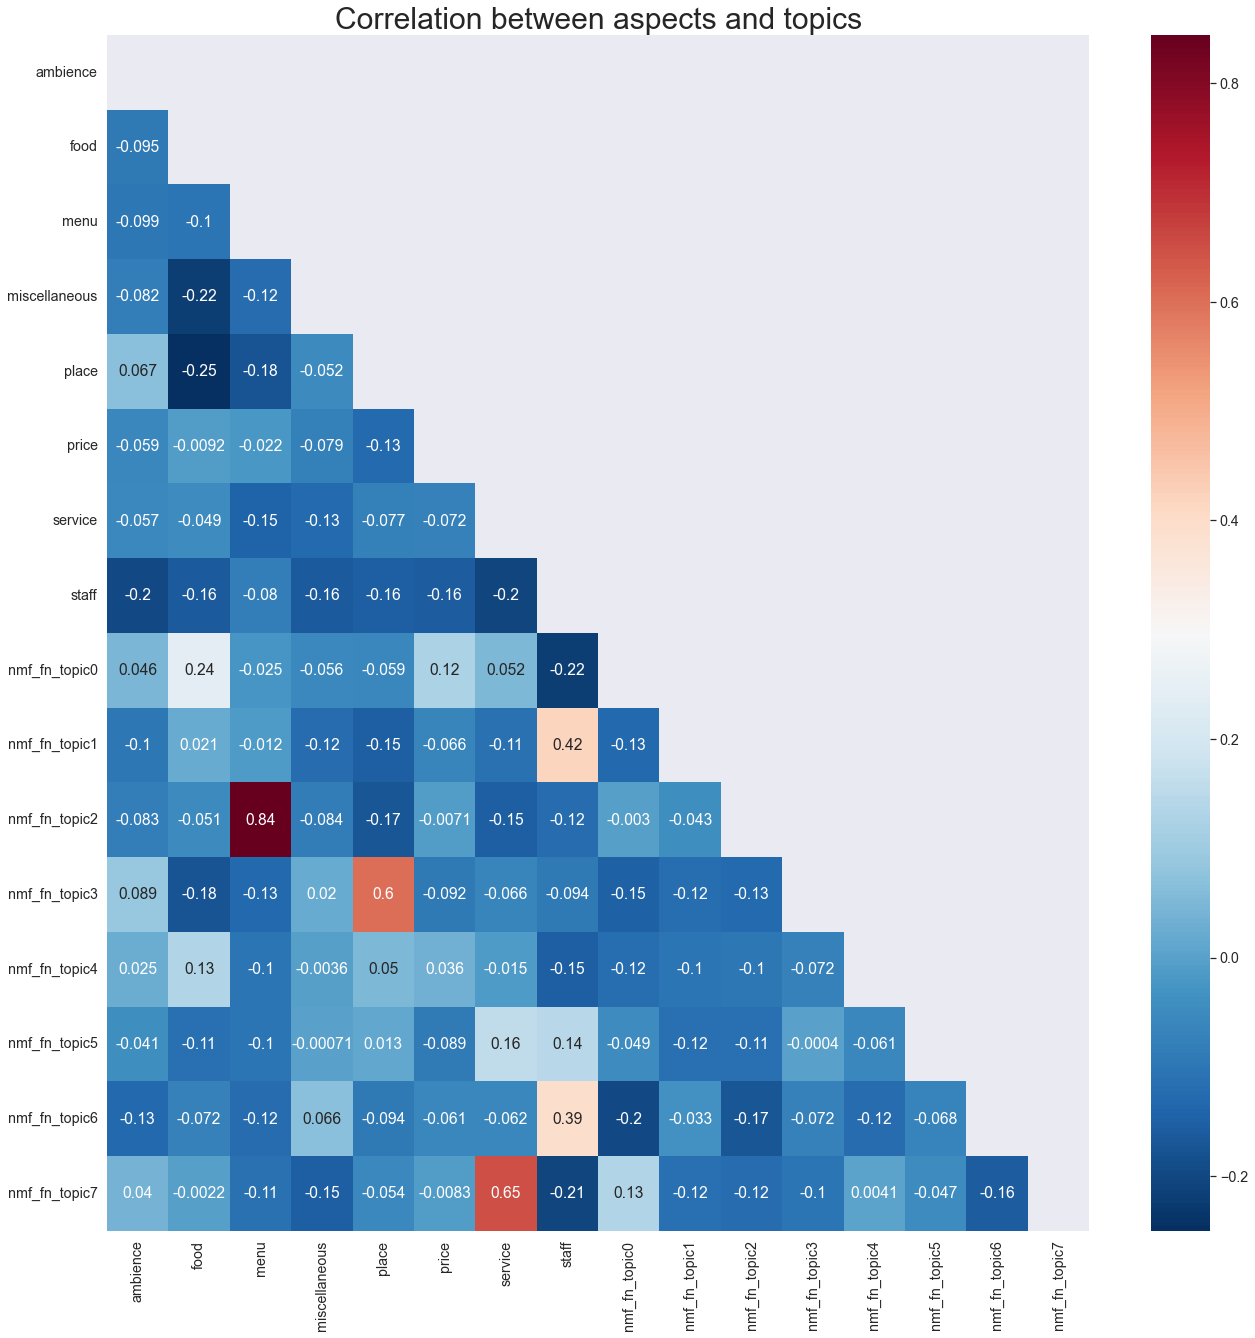

In [16]:
# Correlation between topics and aspects
topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [17]:
# Assign aspects to topics 
nmf_fnTopic_to_aspect = {
    0: [],
    1: ['staff'],
    2: ['menu'],
    3: ['place'],
    4: [],
    5: [],
    6: ['staff'], 
    7: ['service']
}

In [18]:
# Save the model
joblib.dump(nmf_fn, 'nmf_fn.pkl');

## 3. NMF using generalized Kullback-Leibler divergence

/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/mahsa/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


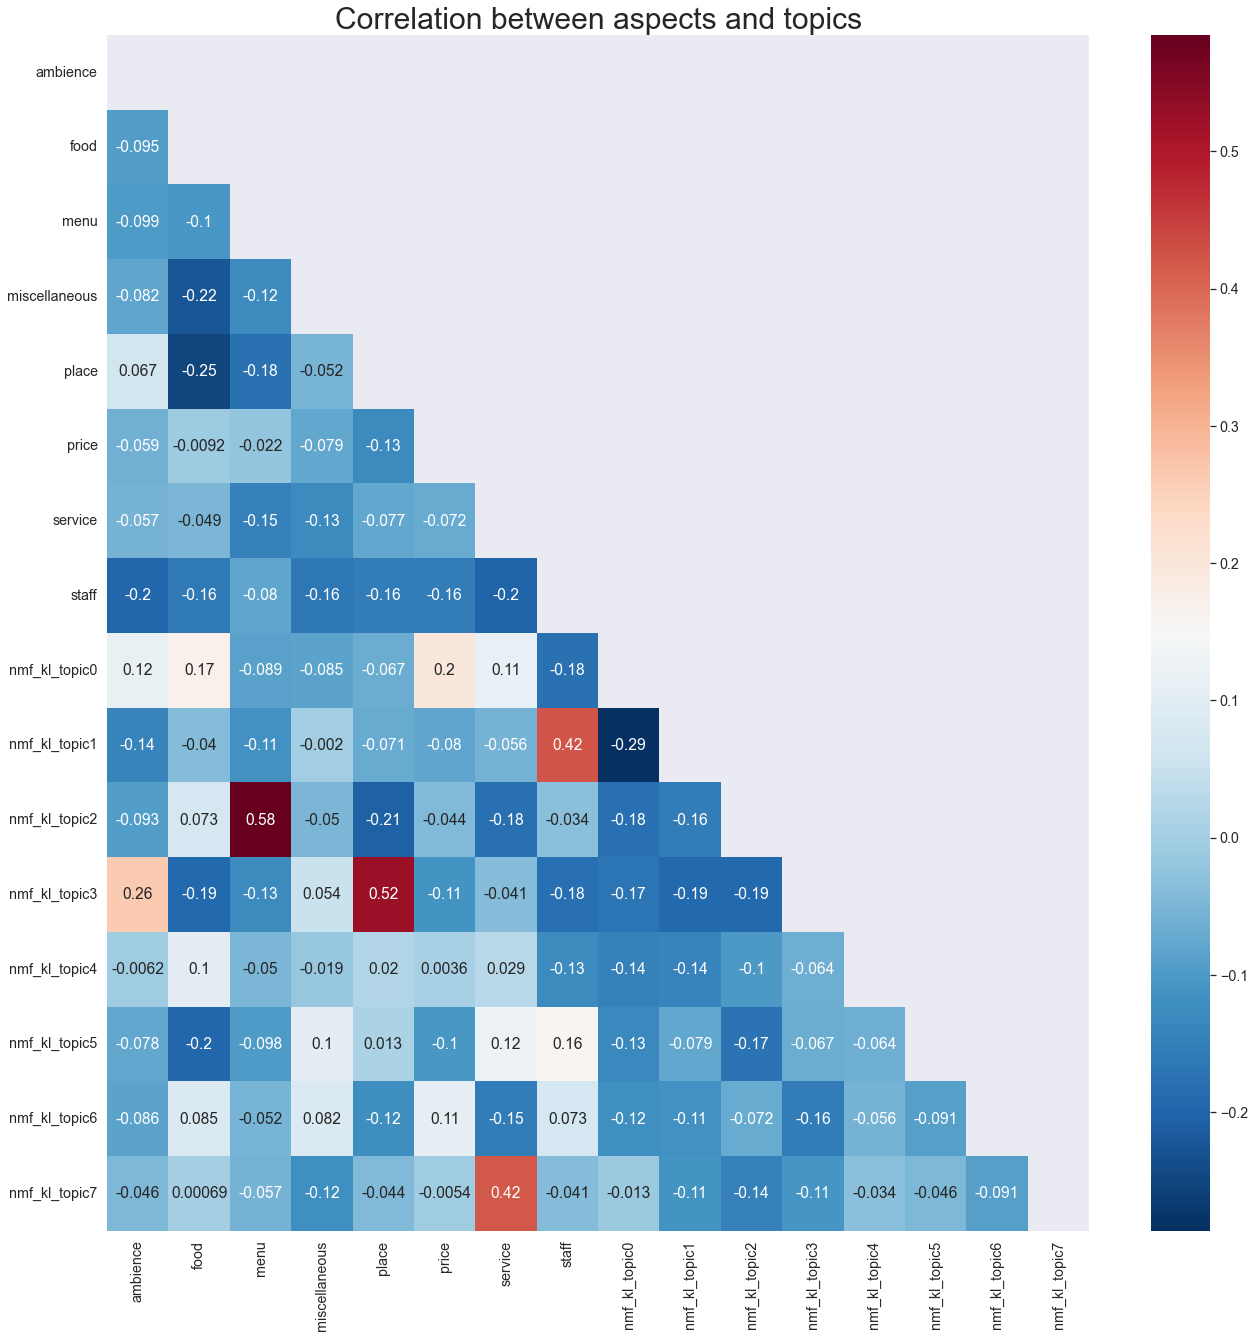

In [19]:
nmf_kl = NMF(n_components=8, random_state=123, beta_loss="kullback-leibler",
             solver="mu", max_iter=1000)

reviews_topics = nmf_kl.fit_transform(X)
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['nmf_kl_topic' + str(col) for col in reviews_topics.columns]

topics_aspects = pd.concat([train.drop('review', axis=1), reviews_topics], axis=1)
topic_aspect_corplot(topics_aspects)

In [20]:
# Assign aspects to topics 
nmf_klTopic_to_aspect = {
    0: ['price', 'food'],
    1: ['staff'],
    2: ['menu'],
    3: ['place', 'ambience'],
    4: [],
    5: [],
    6: [],
    7: ['service']
}

In [21]:
# Save the  model
joblib.dump(nmf_fn, 'nmf_kl.pkl');